In [1]:
! pip install --upgrade kneed
! pip install jenkspy
! pip install rasterio

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import statsmodels.api as sm
import rasterio as rio
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
#debugging
!pip install icecream

In [4]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/BEGUN/Sistem. Intel/Proyecto/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Aquí caragamos el DataFrame totalmente corregido

In [5]:
df_Flujo_calor = pd.read_csv(path+'df_Flujo_calor2.csv', index_col= 0)
df_Flujo_calor.shape

(1049, 10)

In [6]:
df_Flujo_calor.head()


,Codigo,lon,lat,Profundidad,Flujo_calor,Pesos,Flux_x_wts,geometry,Sed_thickness (m),Age (Ma)
0,27HF23,-86.86670,3.537222,-2136.0,65.85,0.942231,62.045937,POINT (-86.86669999999998 3.537222222),279.0,10.1
1,28HF24,-86.99115,2.950989,-2870.0,267.00,0.792270,211.536033,POINT (-86.99115 2.950988889),211.0,7.6
2,29HF25,-86.90680,2.720539,-2690.0,211.00,0.792270,167.168925,POINT (-86.90679999999998 2.720538889),203.0,5.9
3,31HF27,-87.01960,2.150989,-2824.0,187.00,0.660685,123.548114,POINT (-87.0196 2.150988889),159.0,3.6
4,32HF28,-87.05290,2.034306,-2503.0,234.00,0.660685,154.600314,POINT (-87.05289999999999 2.0343055555),145.0,3.1


## Etapa térmica según Pollack (1993)
---
Este autor define 10 etapas térmicas relacionadas con el flujo de calor y la edad geológica de la corteza oceánica. Con el fin de determinar la etapa térmica aproximada para la Cuenca de Panamá, se decide crear una variable de categorías ordinales derivada de la variable flujo de calor para así observar la proporción de los datos según las categorías o etapas térmicas.

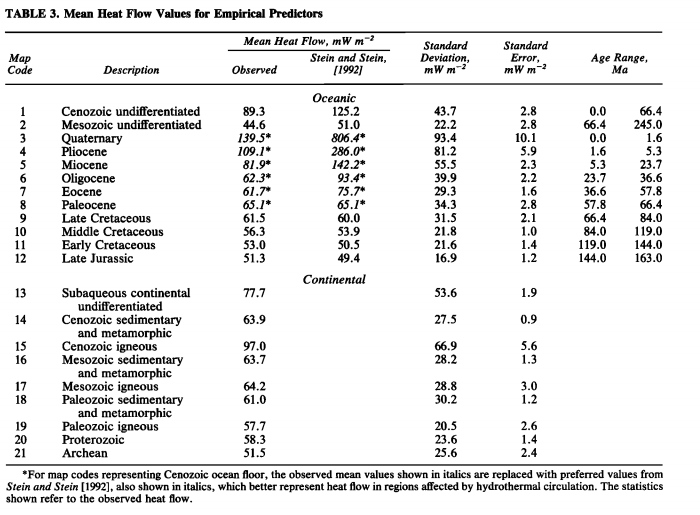

In [7]:
l1= [139.5, 109.1, 81.9, 62.3, 61.7, 65.1, 61.5, 56.3, 53.0, 51.3]
l2= [109.1, 81.9, 62.3, 61.7, 65.1, 61.5, 56.3, 53.0, 51.3]
max = [df_Flujo_calor['Flux_x_wts'].max()]
min = [df_Flujo_calor['Flux_x_wts'].min()]
l3= list(map(lambda item1, item2: (item1 + item2)/2, l1, l2))

valor_medio= max + l3 + min


Periodo_geo= ['Quaternary', 'Pliocene', 'Miocene', 'Oligocene', 
              'Eocene', 'Paleocene', 'Late Cretaceous', 'Middle Cretaceous', 
              'Early Cretaceous', 'Late Jurassic']



df_Flujo_calor['Etapa_termica'] = df_Flujo_calor.Flux_x_wts.map( lambda x: Periodo_geo[0] if valor_medio[0] >= x >= valor_medio[1] else Periodo_geo[1] if valor_medio[1] >= x >= valor_medio[2] else Periodo_geo[2] if valor_medio[2] >= x >= valor_medio[3] else Periodo_geo[3] if valor_medio[3] >= x >= valor_medio[4] else Periodo_geo[4] if valor_medio[4] >= x >= valor_medio[5] else Periodo_geo[5] if valor_medio[5] >= x >= valor_medio[6] else Periodo_geo[6] if valor_medio[6] >= x >= valor_medio[7] else Periodo_geo[7] if valor_medio[7] >= x >= valor_medio[8] else Periodo_geo[8] if valor_medio[8] >= x >= valor_medio[9] else Periodo_geo[9] if valor_medio[9] >= x >= valor_medio[10] else False) 
df_Flujo_calor.head()

,Codigo,lon,lat,Profundidad,Flujo_calor,Pesos,Flux_x_wts,geometry,Sed_thickness (m),Age (Ma),Etapa_termica
0,27HF23,-86.86670,3.537222,-2136.0,65.85,0.942231,62.045937,POINT (-86.86669999999998 3.537222222),279.0,10.1,Oligocene
1,28HF24,-86.99115,2.950989,-2870.0,267.00,0.792270,211.536033,POINT (-86.99115 2.950988889),211.0,7.6,Quaternary
2,29HF25,-86.90680,2.720539,-2690.0,211.00,0.792270,167.168925,POINT (-86.90679999999998 2.720538889),203.0,5.9,Quaternary
3,31HF27,-87.01960,2.150989,-2824.0,187.00,0.660685,123.548114,POINT (-87.0196 2.150988889),159.0,3.6,Pliocene
4,32HF28,-87.05290,2.034306,-2503.0,234.00,0.660685,154.600314,POINT (-87.05289999999999 2.0343055555),145.0,3.1,Quaternary


In [8]:
fig = px.bar(df_Flujo_calor, x='Etapa_termica', y='Flujo_calor', color='Flujo_calor', labels='Flujo_calor', log_y=False)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'array', 'categoryarray':Periodo_geo})
fig.show()

Se observa que la mayoría de los datos de flujo de calor se agrupan en las épocas correspondientes al Cenozoico Tardío, sin embargo, se observa un segundo grupo menor con datos de flujo de calor con edades correspondientes al Mesozoico.

## Flujo de Calor vs. Grosor Sed. vs. Edad 
---
.

Convertimos la variable categorica ordinal 'Etapa_termica' en una variable numérica de 1 a 10 llamada 'No_etapa'

In [9]:
df_Flujo_calor['No_etapa']= df_Flujo_calor.Etapa_termica.map( lambda x: 1 if x == Periodo_geo[0] else 2 if x == Periodo_geo[1] else 3 if x == Periodo_geo[2] else 4 if x == Periodo_geo[3] else 5 if x == Periodo_geo[4] else 6 if x == Periodo_geo[5] else 7 if x == Periodo_geo[6] else 8 if x == Periodo_geo[7] else 9 if x == Periodo_geo[8] else 10 if x == Periodo_geo[9] else False) 
df_Flujo_calor.head()

,Codigo,lon,lat,Profundidad,Flujo_calor,Pesos,Flux_x_wts,geometry,Sed_thickness (m),Age (Ma),Etapa_termica,No_etapa
0,27HF23,-86.86670,3.537222,-2136.0,65.85,0.942231,62.045937,POINT (-86.86669999999998 3.537222222),279.0,10.1,Oligocene,4
1,28HF24,-86.99115,2.950989,-2870.0,267.00,0.792270,211.536033,POINT (-86.99115 2.950988889),211.0,7.6,Quaternary,1
2,29HF25,-86.90680,2.720539,-2690.0,211.00,0.792270,167.168925,POINT (-86.90679999999998 2.720538889),203.0,5.9,Quaternary,1
3,31HF27,-87.01960,2.150989,-2824.0,187.00,0.660685,123.548114,POINT (-87.0196 2.150988889),159.0,3.6,Pliocene,2
4,32HF28,-87.05290,2.034306,-2503.0,234.00,0.660685,154.600314,POINT (-87.05289999999999 2.0343055555),145.0,3.1,Quaternary,1


In [10]:
#Selecciona sólo las variable numéricas del df
df_numeric = df_Flujo_calor.select_dtypes(include=np.number)
varnumericas = list(df_numeric.columns) 
varnumericas

['lon',
 'lat',
 'Profundidad',
 'Flujo_calor',
 'Pesos',
 'Flux_x_wts',
 'Sed_thickness (m)',
 'Age (Ma)',
 'No_etapa']

Se realiza una matriz escater de los datos segun el clasificador de etapas de flujo de calor.

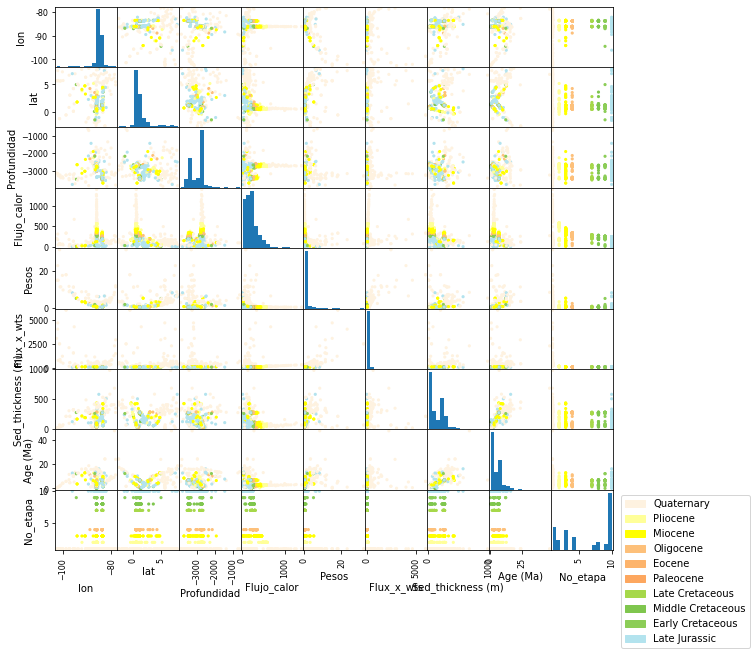

In [11]:
from sklearn.model_selection import train_test_split
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

X = df_Flujo_calor[varnumericas]
y = df_Flujo_calor['No_etapa']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

cmap = ListedColormap(['#FEF2E0', '#FFFF99', '#FFFF00','#FDC07A', '#FDB46C', '#FDA75F', '#A6D84A', '#7FC64E', '#8CCD57', '#B3E3EE'])
scatter = pd.plotting.scatter_matrix(X_train, c= y_train, marker = 'o', s=10, hist_kwds={'bins':15}, figsize=(10,10), cmap=cmap, alpha=1)
patch0 = mpatches.Patch(color='#FEF2E0', label='Quaternary')
patch1 = mpatches.Patch(color='#FFFF99', label='Pliocene')
patch2 = mpatches.Patch(color='#FFFF00', label='Miocene')
patch3 = mpatches.Patch(color='#FDC07A', label='Oligocene')
patch4 = mpatches.Patch(color='#FDB46C', label='Eocene')
patch5 = mpatches.Patch(color='#FDA75F', label='Paleocene')
patch6 = mpatches.Patch(color='#A6D84A', label='Late Cretaceous')
patch7 = mpatches.Patch(color='#7FC64E', label='Middle Cretaceous')
patch8 = mpatches.Patch(color='#8CCD57', label='Early Cretaceous')
patch9 = mpatches.Patch(color='#B3E3EE', label='Late Jurassic')
plt.legend(handles=[patch0, patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9], bbox_to_anchor=(1.05, 1));

In [12]:
cmap = ['#FEF2E0', '#FFFF99', '#FFFF00','#FDC07A', '#FDB46C', '#FDA75F', '#A6D84A', '#7FC64E', '#8CCD57', '#B3E3EE']
fig = go.Figure(data=[go.Scatter3d(
    x=X_train['lon'],
    y=X_train['lat'],
    z=X_train['Profundidad'],
    mode='markers',
    marker=dict(
        size=7,
        color=y_train,               # set color to an array/list of desired values
        colorscale=cmap,    # choose a colorscale
        opacity=0.8
    )
)])
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

## Flujo de Calor vs. Grosor Sedimentario
---
haciendo diferentes graficas para observar la realción entre estas dos variables se intenta ver que si hay una relación exponenecial entre las mismas; que ha mayor temperatura menor grosor sedimentario y viceversa. Sin embargo, No todos los datos sugieren esta relación muchos datos de flujo de calor bajo corresponden a cubierta sedimentaria delgada.

También se hace una regresión logarítmica pero esta parece estar siendo jalada por un punto con gran densidad de datos correspondiente posiblemente al área con muestreo más denso.

In [13]:
#Flujo de calor vs. grosor sedimentario
fig = px.scatter(df_Flujo_calor, x="Sed_thickness (m)", y="Flujo_calor", size="Sed_thickness (m)", color="Flujo_calor", marginal_x='histogram', marginal_y='histogram',)
fig.show()

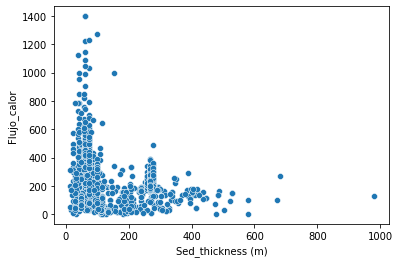

In [14]:
sns.scatterplot(data=df_Flujo_calor, x="Sed_thickness (m)", y="Flujo_calor");

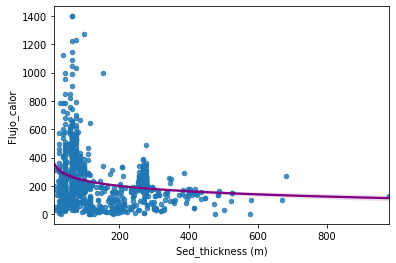

In [15]:
ax = sns.regplot(x="Sed_thickness (m)", y="Flujo_calor", data=df_Flujo_calor,
                 scatter_kws={"s": 20}, line_kws={'color':'purple'},
                 logx=True)

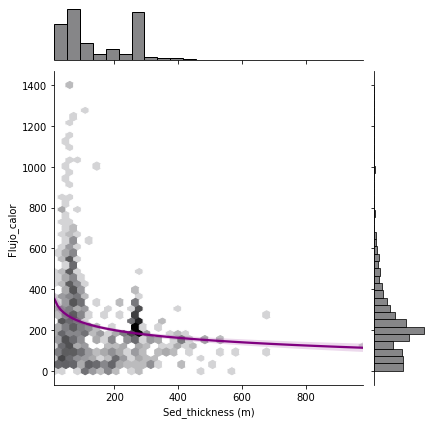

In [16]:
g = sns.jointplot(data=df_Flujo_calor, x='Sed_thickness (m)', y='Flujo_calor', kind="hex", color="#5d5d60",
                  joint_kws={'gridsize':40, 'bins':'log'})
sns.regplot(data=df_Flujo_calor, x='Sed_thickness (m)', y='Flujo_calor', ax=g.ax_joint, scatter=False, line_kws={'color':'purple'},
                 logx=True);

## Flujo de Calor vs. Edad
---


In [17]:
#Flujo de calor vs. grosor sedimentario
fig = px.scatter(df_Flujo_calor, x="Age (Ma)", y="Flujo_calor", size="Age (Ma)", color="Flujo_calor", marginal_x='histogram', marginal_y='histogram',)
fig.show()

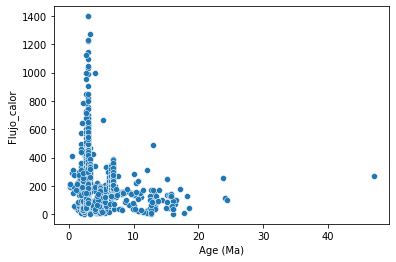

In [18]:
sns.scatterplot(data=df_Flujo_calor, x="Age (Ma)", y="Flujo_calor");

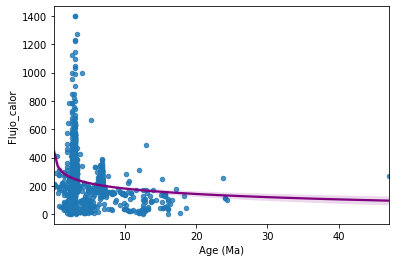

In [19]:
ax = sns.regplot(x="Age (Ma)", y="Flujo_calor", data=df_Flujo_calor,
                 scatter_kws={"s": 20}, line_kws={'color':'purple'},
                 logx=True);

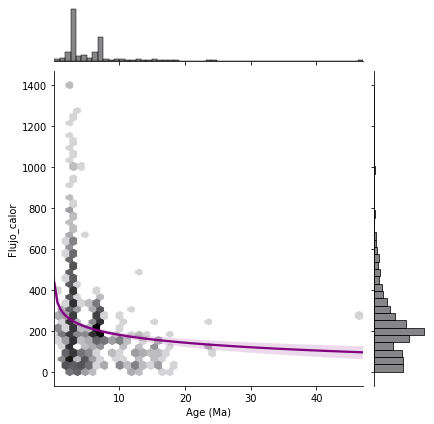

In [20]:
g = sns.jointplot(data=df_Flujo_calor, x='Age (Ma)', y='Flujo_calor', kind="hex", color="#5d5d60",
                  joint_kws={'gridsize':40, 'bins':'log'})
sns.regplot(data=df_Flujo_calor, x='Age (Ma)', y='Flujo_calor', ax=g.ax_joint, scatter=False, line_kws={'color':'purple'},
                 logx=True);

# Grosor Sedomentario vs. Edad
---
Tambien se pretende mediante un scatter plot mirar la relación entre estas dos variables

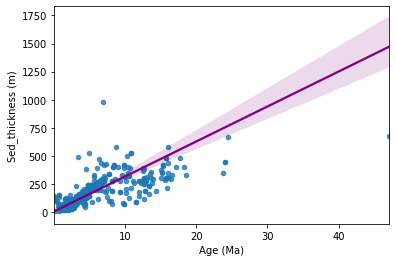

In [21]:
ax = sns.regplot(x="Age (Ma)", y="Sed_thickness (m)", data=df_Flujo_calor,
                 scatter_kws={"s": 20}, line_kws={'color':'purple'}, robust= True);

In [22]:
df_corr= df_Flujo_calor.corr(method= 'spearman')
df_corr

,lon,lat,Profundidad,Flujo_calor,Pesos,Flux_x_wts,Sed_thickness (m),Age (Ma),No_etapa
lon,1.000000,0.337465,-0.508017,0.019741,0.288424,-0.051878,0.502283,0.383948,0.087799
lat,0.337465,1.000000,-0.414431,-0.445266,0.664839,-0.017246,0.400044,0.304595,0.006079
Profundidad,-0.508017,-0.414431,1.000000,0.147085,-0.502250,0.020041,-0.620115,-0.539511,-0.051570
Flujo_calor,0.019741,-0.445266,0.147085,1.000000,-0.455067,0.540238,-0.158766,-0.099010,-0.473341
Pesos,0.288424,0.664839,-0.502250,-0.455067,1.000000,0.291948,0.732652,0.701711,-0.278355
Flux_x_wts,-0.051878,-0.017246,0.020041,0.540238,0.291948,1.000000,0.233244,0.332362,-0.963843
Sed_thickness (m),0.502283,0.400044,-0.620115,-0.158766,0.732652,0.233244,1.000000,0.882394,-0.191385
Age (Ma),0.383948,0.304595,-0.539511,-0.099010,0.701711,0.332362,0.882394,1.000000,-0.286741
No_etapa,0.087799,0.006079,-0.051570,-0.473341,-0.278355,-0.963843,-0.191385,-0.286741,1.000000


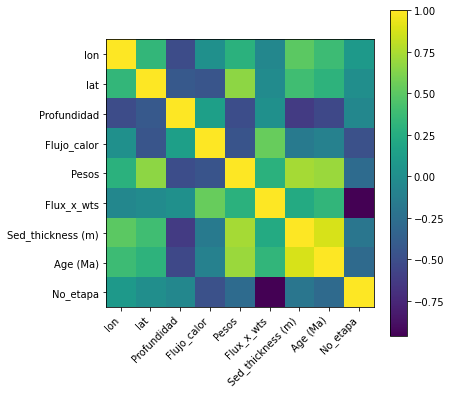

In [23]:

#px.imshow(df_corr)
fig_cor, axes_cor = plt.subplots(1,1)
fig_cor.set_size_inches(6, 6)

labels = varnumericas

myimage = axes_cor.imshow(df_corr)

plt.colorbar(myimage)
axes_cor.set_xticks(np.arange(0,df_corr.shape[0], df_corr.shape[0]*1.0/len(labels)))
axes_cor.set_yticks(np.arange(0,df_corr.shape[1], df_corr.shape[1]*1.0/len(labels)))

axes_cor.set_xticklabels(labels, rotation=45, horizontalalignment="right")
axes_cor.set_yticklabels(labels);

###  Relación $12*1/\sqrt{Edad}$
---
No se observo relación lineal clara ni tampoco exponenecial
puede estar oscurecida por la cncentración de datos del dominio con mayor muestreo, en cierto puento parece haber un patron lineal pero no es realmente claro puede ser sólo especulación.





1. lo primero es pasar el flujo de calor de $mW/m^2$ a HFU

1 HFU = 41.87 mW m-2

In [24]:
df_Flujo_calor['HFU'] = list(map(lambda x : x/41.87, df_Flujo_calor['Flujo_calor']))

mover = df_Flujo_calor.pop('HFU')
df_Flujo_calor.insert(5, 'HFU', mover)
df_Flujo_calor.head()

,Codigo,lon,lat,Profundidad,Flujo_calor,HFU,Pesos,Flux_x_wts,geometry,Sed_thickness (m),Age (Ma),Etapa_termica,No_etapa
0,27HF23,-86.86670,3.537222,-2136.0,65.85,1.572725,0.942231,62.045937,POINT (-86.86669999999998 3.537222222),279.0,10.1,Oligocene,4
1,28HF24,-86.99115,2.950989,-2870.0,267.00,6.376881,0.792270,211.536033,POINT (-86.99115 2.950988889),211.0,7.6,Quaternary,1
2,29HF25,-86.90680,2.720539,-2690.0,211.00,5.039408,0.792270,167.168925,POINT (-86.90679999999998 2.720538889),203.0,5.9,Quaternary,1
3,31HF27,-87.01960,2.150989,-2824.0,187.00,4.466205,0.660685,123.548114,POINT (-87.0196 2.150988889),159.0,3.6,Pliocene,2
4,32HF28,-87.05290,2.034306,-2503.0,234.00,5.588727,0.660685,154.600314,POINT (-87.05289999999999 2.0343055555),145.0,3.1,Quaternary,1


2. Es crear otra columna flujo de calor teórico $q = 12*1/\sqrt{Edad}$
3. Crea otra columna con la diferencia entre las observaicones de flujo de calor y los valores 

In [25]:
df_Flujo_calor['Lister HFU'] = list(map(lambda t: 12*(t**-0.5), df_Flujo_calor['Age (Ma)']))
df_Flujo_calor['obs-teo HFU'] = df_Flujo_calor['HFU'] - df_Flujo_calor['Lister HFU']
df_Flujo_calor.head()

,Codigo,lon,lat,Profundidad,Flujo_calor,HFU,Pesos,Flux_x_wts,geometry,Sed_thickness (m),Age (Ma),Etapa_termica,No_etapa,Lister HFU,obs-teo HFU
0,27HF23,-86.86670,3.537222,-2136.0,65.85,1.572725,0.942231,62.045937,POINT (-86.86669999999998 3.537222222),279.0,10.1,Oligocene,4,3.775901,-2.203176
1,28HF24,-86.99115,2.950989,-2870.0,267.00,6.376881,0.792270,211.536033,POINT (-86.99115 2.950988889),211.0,7.6,Quaternary,1,4.352858,2.024023
2,29HF25,-86.90680,2.720539,-2690.0,211.00,5.039408,0.792270,167.168925,POINT (-86.90679999999998 2.720538889),203.0,5.9,Quaternary,1,4.940322,0.099086
3,31HF27,-87.01960,2.150989,-2824.0,187.00,4.466205,0.660685,123.548114,POINT (-87.0196 2.150988889),159.0,3.6,Pliocene,2,6.324555,-1.858350
4,32HF28,-87.05290,2.034306,-2503.0,234.00,5.588727,0.660685,154.600314,POINT (-87.05289999999999 2.0343055555),145.0,3.1,Quaternary,1,6.815542,-1.226815


3. Graficamos la el modelo de Lister(1977) y promediamos los datos de flujo de calor de la cuenca para ver si cae dentro del modelo sino se supone que segun el autor algo de hidrotermalismo está sucediendo

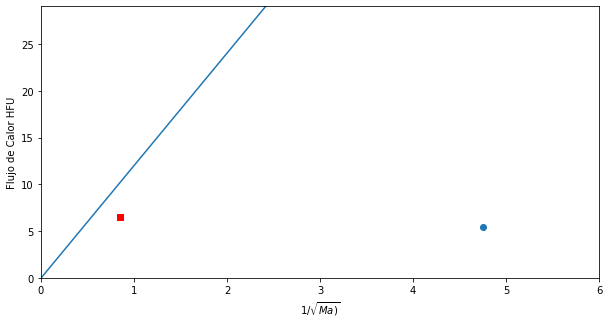

In [26]:
# A partir del promedio HFU de toda la cuenca hallamos la edad teórica
q = df_Flujo_calor['HFU'].mean()
t = (12/q)**2

# Graficamos la relación lineal entre q vs. t
x2 = np.linspace(0, 40, 40)
y2= 12*x2

Davis_y= (6.1 +7)/2
Davis_x= 1/(1.4**0.5)

fig = plt.figure(figsize = (10, 5)) 

# Create the plot 
plt.scatter(t, q) 
plt.scatter(Davis_x, Davis_y, marker='s', c='r') 
plt.plot(x2, y2)
plt.xlim(0, 6)
plt.ylim(0, 29)
#Etiquetas
plt.xlabel('$1/\sqrt{Ma)}$')
plt.ylabel('Flujo de Calor HFU')  
# Show the plot 
plt.savefig("Lister model.jpg")
plt.show() 


## Comparación $HFU_{obs.} - HFU_{teo.}$
---
En este punto se comparan los valores de flujo de calor observados con los teoricos calculados apartir de modelo de Lister (1977).


Se en cuentra que a menor edad y menor grosor sedimentario el flujo de calor es más frío de lo que se espera mientras que entre 2-5 Ma y 50 -100 m de grosor sedimentario el flujo de calor es más alto de los esperdo. Entro los 100 -200 m de grosor el flujo de calor es más frío de lo esperado.

a intervlos mayores a 5 Ma Y 200 m el flujo de calor es muy semejante a lo esperado por el modelo por lo que el modelo de Lister(1977) empieza a ser confiable para la cuenca de Panamá

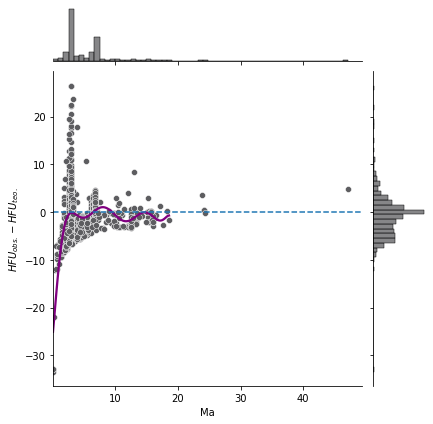

In [27]:
# Creating vectors X and Y 
x = df_Flujo_calor['Age (Ma)']
y = df_Flujo_calor['obs-teo HFU']

#agrupamos los datos donde la edad es menor a 20 Ma sólo para maostrar una regresión más corta
grupo = df_Flujo_calor[df_Flujo_calor['Age (Ma)'] < 20]
x2 = grupo['Age (Ma)']
y2 = grupo['obs-teo HFU']

g = sns.jointplot(data=df_Flujo_calor, x= x, y= y, kind="scatter", color="#5d5d60")
r = sns.regplot(data=df_Flujo_calor, x= x2, y= y2, ax=g.ax_joint, scatter=False, line_kws={'color':'purple'}, order=9, ci= True);
g.set_axis_labels("Ma", "$HFU_{obs.} - HFU_{teo.}$")
#g.ax_joint.set_yscale('log')
r.axhline(0, ls='--');



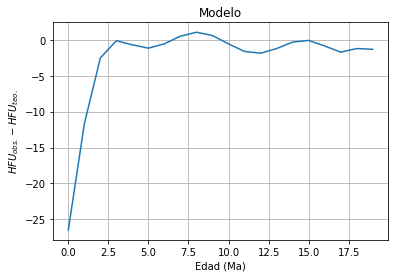

In [28]:
degree = 9
weights = np.polyfit(x2, y2, degree)

model = np.poly1d(weights)
p9 = np.poly1d(model)

xp = np.arange(20)
yp = p9(xp)


fig, ax = plt.subplots()
ax.plot(xp, yp)

ax.set(xlabel='Edad (Ma)', ylabel='$HFU_{obs.} - HFU_{teo.}$',
       title='Modelo')
ax.grid()


plt.show();

In [29]:
#modelo matemático para HFU_obs - HFU_teo vs. Edad
print ("P9 : ", p9) 

P9 :              9             8           7           6          5
-3.742e-07 x + 3.273e-05 x - 0.00119 x + 0.02323 x - 0.2612 x
          4         3         2
 + 1.673 x - 5.467 x + 5.155 x + 13.65 x - 26.46


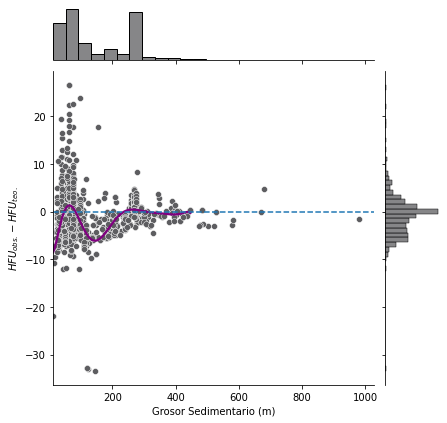

In [30]:
# Creating vectors X and Y 
x = df_Flujo_calor['Sed_thickness (m)']
y = df_Flujo_calor['HFU'] - df_Flujo_calor['Lister HFU']

#agrupamos los datos donde el grosor sedimentario es menor a 480 m sólo para maostrar una regresión más corta
grupo = df_Flujo_calor[df_Flujo_calor['Sed_thickness (m)'] < 450]
x2 = grupo['Sed_thickness (m)']
y2 = grupo['obs-teo HFU']

g = sns.jointplot(data=df_Flujo_calor, x= x, y= y, kind="scatter", color="#5d5d60")
r = sns.regplot(x= x2, y= y2, data=df_Flujo_calor, ax=g.ax_joint, scatter=False,
                 scatter_kws={"s": 20}, line_kws={'color':'purple'},
                 order=9, ci= True)
r.axhline(0, ls='--')                 
g.set_axis_labels("Grosor Sedimentario (m)", "$HFU_{obs.} - HFU_{teo.}$");                

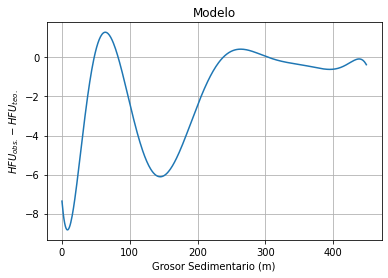

In [31]:
degree = 9
weights = np.polyfit(x2, y2, degree)

model = np.poly1d(weights)
p9 = np.poly1d(model)

xp = np.arange(450)
yp = p9(xp)
#plt.plot(xp, yp);

fig, ax = plt.subplots()
ax.plot(xp, yp)

ax.set(xlabel='Grosor Sedimentario (m)', ylabel='$HFU_{obs.} - HFU_{teo.}$',
       title='Modelo')
ax.grid()


plt.show()


In [32]:

#modelo matemático para HFU_obs - HFU_teo vs. gresor sedimentario
print ("P9 : ", p9) 

P9 :              9             8            7             6             5
-1.101e-19 x + 2.476e-16 x - 2.35e-13 x + 1.219e-10 x - 3.728e-08 x
              4             3           2
 + 6.742e-06 x - 0.0006788 x + 0.03218 x - 0.4017 x - 7.359


# KNN
---
¿Que se hizo?

Primero se entranó un modelo KNN con todas las variables numéricas de los datos (es decir que pasaría si el modelo conociera bien la naturaleza de cada zona, es decir grososr sedimentario, edad de la corteza, etc.). Por eso entrenamos un modelo con muchas variables para conocer el mejor conjunto de hiperparámetros **vecinos-k** y **train size**.

Depues con estos dos hiperparámetros definimos entrenamos un conjunto sólo con las coordenadas para que el nos clasisfique gegráficmaente zonas donde se puede aplicar el modelo Lister y zonas en las que no.

1. Sacamos los puntos naturales de quibre del histograma de $HFU_{obs.} - HFU_{teo.}$ para sacar los humbrales para las categorias 3 categorías: Frio, Caliente, neutro

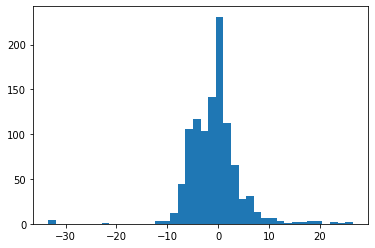

In [33]:
plt.hist(df_Flujo_calor['obs-teo HFU'], bins= 40);

In [34]:
#con este paquete se haya los puntos de quiebre naturales del histograma
import jenkspy

breaks = jenkspy.jenks_breaks(df_Flujo_calor['obs-teo HFU'], nb_class=3)
breaks

[-33.3617097581801, -2.43811486151506, 5.228472193655708, 26.460858150187832]

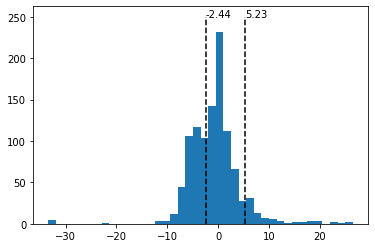

In [35]:
Varible = df_Flujo_calor['obs-teo HFU'] 
plt.hist(Varible, bins= 40)
min_Varible= 0
max_Varible= 250

plt.plot([breaks[1],breaks[1]],[min_Varible,max_Varible],color = 'black',linestyle='dashed');
plt.plot([breaks[2],breaks[2]],[min_Varible,max_Varible],color = 'black',linestyle='dashed');

plt.text(breaks[1], max_Varible, f'{breaks[1]:.2f}');
plt.text(breaks[2], max_Varible, f'{breaks[2]:.2f}');

1. 1 Los valores del clasificador serán Frío $(q<-2.44)$, neutro $(-2.44<q<5.23)$ y calientes $(5.23<q)$

2. Creamos la columna 'Clasificador'

In [36]:
df_Flujo_calor['Clasificador'] = list(map( lambda x: 'Frío' if x < -2.44 else 'Neutro' if -2.44 < x < 5.23 else 'Caliente' if 5.23 < x else False, df_Flujo_calor['obs-teo HFU'])) 
df_Flujo_calor.head()

,Codigo,lon,lat,Profundidad,Flujo_calor,HFU,Pesos,Flux_x_wts,geometry,Sed_thickness (m),Age (Ma),Etapa_termica,No_etapa,Lister HFU,obs-teo HFU,Clasificador
0,27HF23,-86.86670,3.537222,-2136.0,65.85,1.572725,0.942231,62.045937,POINT (-86.86669999999998 3.537222222),279.0,10.1,Oligocene,4,3.775901,-2.203176,Neutro
1,28HF24,-86.99115,2.950989,-2870.0,267.00,6.376881,0.792270,211.536033,POINT (-86.99115 2.950988889),211.0,7.6,Quaternary,1,4.352858,2.024023,Neutro
2,29HF25,-86.90680,2.720539,-2690.0,211.00,5.039408,0.792270,167.168925,POINT (-86.90679999999998 2.720538889),203.0,5.9,Quaternary,1,4.940322,0.099086,Neutro
3,31HF27,-87.01960,2.150989,-2824.0,187.00,4.466205,0.660685,123.548114,POINT (-87.0196 2.150988889),159.0,3.6,Pliocene,2,6.324555,-1.858350,Neutro
4,32HF28,-87.05290,2.034306,-2503.0,234.00,5.588727,0.660685,154.600314,POINT (-87.05289999999999 2.0343055555),145.0,3.1,Quaternary,1,6.815542,-1.226815,Neutro


In [37]:
Clase= ['Frío', 'Neutro', 'Caliente']

fig = px.bar(df_Flujo_calor, x='Clasificador', y='Flujo_calor', color='Clasificador', labels='Flujo_calor', log_y=False)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'array', 'categoryarray':Clase})
fig.show()

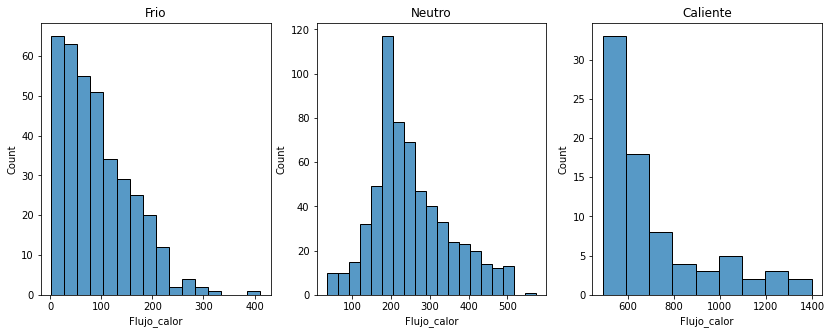

In [38]:
#histograma de los Flujos de calor frios
fig, axes = plt.subplots(1, 3, figsize=(14,5))
axes[0].set_title('Frio')
sns.histplot(df_Flujo_calor[df_Flujo_calor['Clasificador']== 'Frío']['Flujo_calor'], ax=axes[0])

axes[1].set_title('Neutro')
sns.histplot(df_Flujo_calor[df_Flujo_calor['Clasificador']== 'Neutro']['Flujo_calor'], ax=axes[1])

axes[2].set_title('Caliente')
sns.histplot(df_Flujo_calor[df_Flujo_calor['Clasificador']== 'Caliente']['Flujo_calor'], ax=axes[2])

Además, los datos catalogados como fríos son significativamente menores a los catalogados como neutros

In [39]:
#test de Wilcoxon rank-sum test para dos muestras relacionadas
from scipy.stats import wilcoxon
sample1 = df_Flujo_calor[df_Flujo_calor['Clasificador']== 'Frío']['Flujo_calor']
sample2 = df_Flujo_calor[df_Flujo_calor['Clasificador']== 'Neutro']['Flujo_calor']
wilcoxon(sample1, sample2.sample(n= sample1.size), alternative='less')

WilcoxonResult(statistic=2068.5, pvalue=1.6197682177776323e-54)

In [40]:
print(f'p-valor = {round(7.366461444437366e-55)}')

p-valor = 0


## Create train-test split

In [41]:
from sklearn import preprocessing
encode = preprocessing.LabelEncoder()

#codificamos la columna clasificador
df_Flujo_calor['Clasif_encode'] = encode.fit_transform(df_Flujo_calor['Clasificador'])

df_Flujo_calor.head()

,Codigo,lon,lat,Profundidad,Flujo_calor,HFU,Pesos,Flux_x_wts,geometry,Sed_thickness (m),Age (Ma),Etapa_termica,No_etapa,Lister HFU,obs-teo HFU,Clasificador,Clasif_encode
0,27HF23,-86.86670,3.537222,-2136.0,65.85,1.572725,0.942231,62.045937,POINT (-86.86669999999998 3.537222222),279.0,10.1,Oligocene,4,3.775901,-2.203176,Neutro,2
1,28HF24,-86.99115,2.950989,-2870.0,267.00,6.376881,0.792270,211.536033,POINT (-86.99115 2.950988889),211.0,7.6,Quaternary,1,4.352858,2.024023,Neutro,2
2,29HF25,-86.90680,2.720539,-2690.0,211.00,5.039408,0.792270,167.168925,POINT (-86.90679999999998 2.720538889),203.0,5.9,Quaternary,1,4.940322,0.099086,Neutro,2
3,31HF27,-87.01960,2.150989,-2824.0,187.00,4.466205,0.660685,123.548114,POINT (-87.0196 2.150988889),159.0,3.6,Pliocene,2,6.324555,-1.858350,Neutro,2
4,32HF28,-87.05290,2.034306,-2503.0,234.00,5.588727,0.660685,154.600314,POINT (-87.05289999999999 2.0343055555),145.0,3.1,Quaternary,1,6.815542,-1.226815,Neutro,2



Neutro = 2, Frío = 1, Caliente = 0

**20/08/2021:** Se identificó un error grave en la definición de X, dado que se estaba entrenando el modelo sin antes normalizar, por lo que se corrige esto con la función StandardScaler()

In [42]:
from sklearn.preprocessing import StandardScaler

#tomamos las variable numericas y se lo asignamos a la variable varnumericas
df_numeric = df_Flujo_calor.select_dtypes(include=np.number)
varnumericas = list(df_numeric.columns) 
print(f'Variables numéricas para entreno: \n{varnumericas[:-1]}')


# colcoamos las variables en el x y en y el clasificador
X = df_Flujo_calor[varnumericas[:-1]]
scaler = StandardScaler() # Declaramos el Transformer "StandardScaler"
X = scaler.fit_transform(X) 
y = df_Flujo_calor['Clasif_encode']

# default is 75% / 25% train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify= y)
print(f'X_train: {X_train.shape} & y_train {y_train.shape}')
print(f'X_test: {X_test.shape} & y_test: {y_test.shape}')

Variables numéricas para entreno: 
['lon', 'lat', 'Profundidad', 'Flujo_calor', 'HFU', 'Pesos', 'Flux_x_wts', 'Sed_thickness (m)', 'Age (Ma)', 'No_etapa', 'Lister HFU', 'obs-teo HFU']
X_train: (786, 12) & y_train (786,)
X_test: (263, 12) & y_test: (263,)


In [43]:
print(f'Cantidad de categorías en y_train: \n{y_train.value_counts()}')
print(f'Cantidad de categorías en y_test: \n{y_test.value_counts()}')

Cantidad de categorías en y_train: 
2    455
1    273
0     58
Name: Clasif_encode, dtype: int64
Cantidad de categorías en y_test: 
2    152
1     91
0     20
Name: Clasif_encode, dtype: int64


### Sin Validación Cruzada (Best KNeighborsClassifier)
---
Encontramos el mejor n_neighbors

In [44]:
from sklearn.neighbors import KNeighborsClassifier

In [45]:
from tqdm.notebook import tqdm

k_range = range(1,600)
scores = []

for k in tqdm(k_range,
              total= 600-1,
              desc= "Looping over k_range"):
  
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify= y)
    knn = KNeighborsClassifier(n_neighbors = k, weights= 'uniform', n_jobs=-1)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

mean_score= pd.Series(scores).mean()
min_score= pd.Series(scores).min()
max_score= pd.Series(scores).max()

from kneed import KneeLocator

print('############################')
kn0 = KneeLocator(k_range, scores, curve='concave', direction='decreasing', 
                  online=True, interp_method= 'polynomial', polynomial_degree= 4)
print(f'kn0 - Codo de inflexión con Polinomial grado {4} {"concavo"} online={True}: {kn0.knee} (k)')
#kn0.plot_knee()

kn1 = KneeLocator(k_range, scores, curve='concave', direction='decreasing', 
                  online=True, interp_method= 'polynomial', polynomial_degree= 6)
print(f'kn1 - Codo de inflexión con Polinomial grado {6} {"concavo"} online={True}:  {kn1.knee} (k)')
#kn1.plot_knee()

kn2 = KneeLocator(k_range, scores, curve='convex', direction='decreasing', 
                  online=False, interp_method= 'polynomial', polynomial_degree= 4)
print(f'kn2 - Codo de inflexión  Polinomial grado {4} {"convexo"} online={False}: {kn2.knee} (k)')
#kn2.plot_knee()

#kn3 = KneeLocator(k_range, scores, curve='concave', direction='decreasing', 
                  #online= True, interp_method= 'polynomial', polynomial_degree= 6)
#print(f'kn3 - Codo de inflexión  Polinomial grado 3 concavo online= False: {kn3.knee} (k)')
#kn3.plot_knee()

#kn4 = KneeLocator(k_range, scores, curve='convex', direction='decreasing', online=False, interp_method= 'interp1d')
#print(f'kn4 - Codo de inflexión interpolado con función (scipy.interpolate.interp1) convexa online=False: {kn4.knee} (k)')
#kn4.plot_knee()

#kn5 = KneeLocator(k_range, scores, curve='concave', direction='decreasing', online=False, interp_method= 'interp1d')
#print(f'kn5 - Codo de inflexión interpolado con función (scipy.interpolate.interp1) concava online=False: {kn5.knee} (k)')
#kn5.plot_knee()

#kn6 = KneeLocator(k_range, scores, curve='convex', direction='decreasing', online=True, interp_method= 'interp1d')
#print(f'kn6 - Codo de inflexión interpolado con función (scipy.interpolate.interp1) convexa online=True: {kn6.knee} (k)')
#kn6.plot_knee()

#kn7 = KneeLocator(k_range, scores, curve='concave', direction='decreasing', online=True, interp_method= 'interp1d')
#print(f'kn7 - Codo de inflexión interpolado con función (scipy.interpolate.interp1) concava online=True: {kn7.knee} (k)')
#kn7.plot_knee()
print('############################')


Looping over k_range:   0%|          | 0/599 [00:00<?, ?it/s]

############################
kn0 - Codo de inflexión con Polinomial grado 4 concavo online=True: 427 (k)
kn1 - Codo de inflexión con Polinomial grado 6 concavo online=True:  26 (k)
kn2 - Codo de inflexión  Polinomial grado 4 convexo online=False: 109 (k)
############################


Text(9, 0.9771863117870723, 'kn=9')

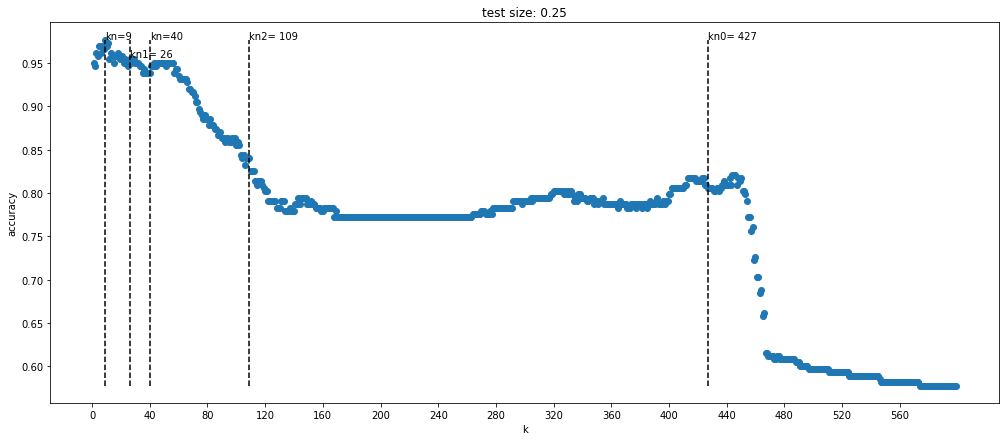

In [46]:

plt.figure(figsize=(17,7))
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks(np.arange(0, 600, 40))
plt.title(f'test size: {0.25}')

plt.plot([kn0.knee,kn0.knee],[min_score,max_score],color = 'black',linestyle='dashed')
plt.plot([kn1.knee,kn1.knee],[min_score,max_score],color = 'black',linestyle='dashed')
plt.plot([kn2.knee,kn2.knee],[min_score,max_score],color = 'black',linestyle='dashed')
plt.plot([40,40],[min_score,max_score],color = 'black',linestyle='dashed')
plt.plot([k_range[scores.index(np.max(scores))],
          k_range[scores.index(np.max(scores))]],
         [min_score,max_score],color = 'black',linestyle='dashed')
#plt.plot([kn5.knee,kn5.knee],[min_score,max_score],color = 'black',linestyle='dashed')
#plt.plot([kn6.knee,kn6.knee],[min_score,max_score],color = 'black',linestyle='dashed')
#plt.plot([kn7.knee,kn7.knee],[min_score,max_score],color = 'black',linestyle='dashed')

plt.text(kn0.knee, max_score, f'kn0= {kn0.knee}')
plt.text(kn1.knee, max_score-0.02, f'kn1= {kn1.knee}')
plt.text(kn2.knee, max_score, f'kn2= {kn2.knee}')
plt.text(40, max_score, r'kn=40');
plt.text(k_range[scores.index(np.max(scores))], 
         max_score, f'kn={k_range[scores.index(np.max(scores))]}')
#plt.text(kn5.knee, max_score, r'kn5')
#plt.text(kn6.knee, max_score, r'kn6')
#plt.text(kn7.knee, max_score, r'kn7');

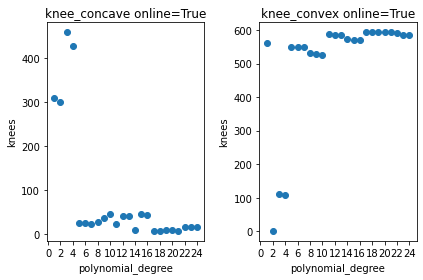

In [47]:
knee_range_concave = range(1, 25)
K_knee_concave = []

for k in knee_range_concave:
  kn4 = KneeLocator(k_range, scores, curve='concave', direction='decreasing', 
                    online=True, interp_method= 'polynomial', polynomial_degree= k)
  K_knee_concave.append(kn4.knee)

knee_range_convex = range(1, 25)
K_knee_convex = []

for k in knee_range_convex:
  kn4 = KneeLocator(k_range, scores, curve='convex', direction='decreasing', 
                    online=True, interp_method= 'polynomial', polynomial_degree= k)
  K_knee_convex.append(kn4.knee)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax0, ax1 = axes
ax0.scatter(knee_range_concave, K_knee_concave)
ax1.scatter(knee_range_convex, K_knee_convex)

ax0.set_title('knee_concave online=True')
ax1.set_title('knee_convex online=True')

ax0.set_ylabel('knees')
ax0.set_xlabel('polynomial_degree')
ax1.set_ylabel('knees')
ax1.set_xlabel('polynomial_degree')

ax0.set_xticks(np.arange(0, 25, 2))
ax1.set_xticks(np.arange(0, 25, 2))

fig.tight_layout();

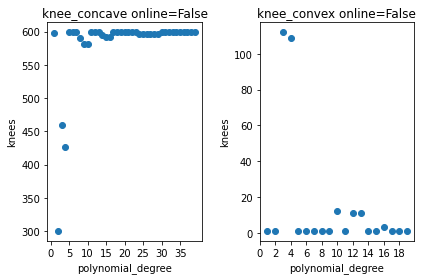

In [48]:
knee_range_concave = range(1,40)
K_knee_concave = []

for k in knee_range_concave:
  kn4 = KneeLocator(k_range, scores, curve='concave', direction='decreasing', 
                    online=False, interp_method= 'polynomial', polynomial_degree= k)
  K_knee_concave.append(kn4.knee)

knee_range_convex = range(1,20)
K_knee_convex = []

for k in knee_range_convex:
  kn4 = KneeLocator(k_range, scores, curve='convex', direction='decreasing', 
                    online=False, interp_method= 'polynomial', polynomial_degree= k)
  K_knee_convex.append(kn4.knee)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax0, ax1 = axes
ax0.scatter(knee_range_concave, K_knee_concave)
ax1.scatter(knee_range_convex, K_knee_convex)

ax0.set_title('knee_concave online=False')
ax1.set_title('knee_convex online=False')

ax0.set_ylabel('knees')
ax0.set_xlabel('polynomial_degree')
ax1.set_ylabel('knees')
ax1.set_xlabel('polynomial_degree')

ax0.set_xticks(np.arange(0, 40, 5))
ax1.set_xticks(np.arange(0, 20, 2))

fig.tight_layout();

14/12/2020: Se encuentra que el codo del modelo KNN es el kn2 - Codo de inflexión  Polinomial grado 4 convexo online=False: 112 (k)

**NUEVO 15/12/2020**: Se probó con 120 como codo pero no dio buenos resultados entonces se observo la gráfica de nuevo y se encontró un hombro en 45. usó y dio buenos resultados. 

que tan sensitivo la exacttud de es nuestra clasificación k-NN a la proporción entrenamiento/test split?

### Validación Cruzada 5 fold (Best KNeighborsClassifier)
---
Encontramos el mejor n_neighbors con una prueba exhaustiva de validación cruzada con 5 validaciones por cada punto de la gráfica

In [49]:
from sklearn.model_selection import cross_val_score

n_neighbors_range = range(1,600)
cv_scores = []

for k in tqdm(n_neighbors_range, 
              total= 599, 
              desc= "Looping over n_neighbors_range"):
  
    knn_cv = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    cv_scores.append(np.mean(cross_val_score(knn_cv, X, y, cv=5, n_jobs=-1)))

mean_score= pd.Series(cv_scores).mean()
min_score= pd.Series(cv_scores).min()
max_score= pd.Series(cv_scores).max()

from kneed import KneeLocator
kn = KneeLocator(k_range, cv_scores, curve='concave', direction='decreasing', 
                 online=True, interp_method= 'polynomial', polynomial_degree= 1)

print('############################')
print(f'kn - Codo de inflexión con Polinomial grado {1} {"concavo"} online={True}: {kn.knee} (k)')
#kn.plot_knee()

kn1 = KneeLocator(k_range, cv_scores, curve='concave', direction='decreasing', 
                  online=True, interp_method= 'polynomial', polynomial_degree= 6)
print(f'kn1 - Codo de inflexión con Polinomial grado {6} {"concavo"} online={True}:  {kn1.knee} (k)')
#kn1.plot_knee()

kn2 = KneeLocator(k_range, cv_scores, curve='convex', direction='decreasing', 
                  online=True, interp_method= 'polynomial', polynomial_degree= 2)
print(f'kn2 - Codo de inflexión con Polinomial grado {2} {"convexo"} online={True}: {kn2.knee} (k)')
#kn2.plot_knee()

kn3 = KneeLocator(k_range, cv_scores, curve='convex', direction='decreasing', 
                  online=False, interp_method= 'polynomial', polynomial_degree= 9)
print(f'kn3 - Codo de inflexión con Polinomial grado {9} {"convexo"} online={False}: {kn3.knee} (k)')
#kn2.plot_knee()
print('############################')


Looping over n_neighbors_range:   0%|          | 0/599 [00:00<?, ?it/s]

############################
kn - Codo de inflexión con Polinomial grado 1 concavo online=True: 9 (k)
kn1 - Codo de inflexión con Polinomial grado 6 concavo online=True:  412 (k)
kn2 - Codo de inflexión con Polinomial grado 2 convexo online=True: 1 (k)
kn3 - Codo de inflexión con Polinomial grado 9 convexo online=False: 21 (k)
############################


"plt.text(k_range[idx_max_score], max_score-0.07, \n         f'kn4= {k_range[idx_max_score]} \nmax_acc:{k_range[idx_max_score]}idx, {cv_scores[idx_max_score]:.2f}acc');"

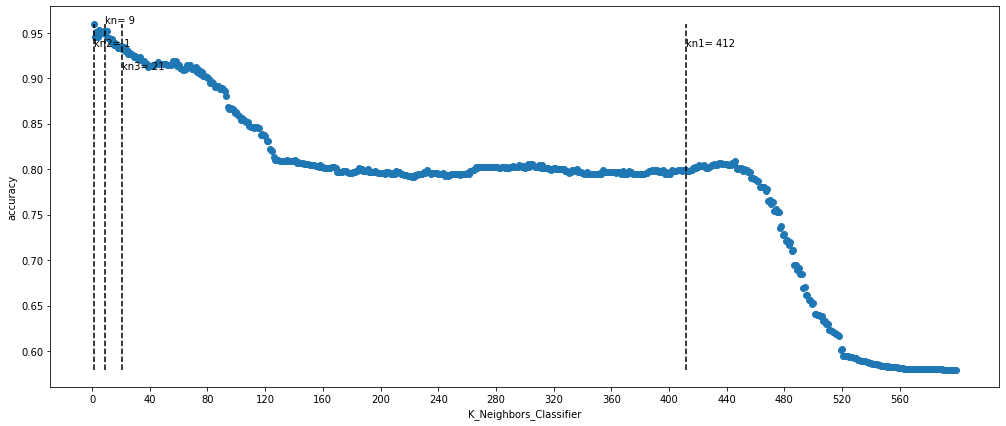

In [50]:

plt.figure(figsize=(17,7))
plt.xlabel('K_Neighbors_Classifier')
plt.ylabel('accuracy')
plt.scatter(k_range, cv_scores)
plt.xticks(np.arange(0, 600, 40))

plt.plot([kn.knee,kn.knee],[min_score,max_score],color = 'black',linestyle='dashed')
plt.plot([kn1.knee,kn1.knee],[min_score,max_score],color = 'black',linestyle='dashed')
plt.plot([kn2.knee,kn2.knee],[min_score,max_score],color = 'black',linestyle='dashed')
plt.plot([kn3.knee,kn3.knee],[min_score,max_score],color = 'black',linestyle='dashed')


plt.text(kn.knee, max_score, f'kn= {kn.knee}')
plt.text(kn1.knee, max_score-0.025, f'kn1= {kn1.knee}')
plt.text(kn2.knee, max_score-0.025, f'kn2= {kn2.knee}')
plt.text(kn3.knee, max_score-0.05, f'kn3= {kn3.knee}');

#idx_max_score = cv_scores.index(np.max(cv_scores))
#plt.plot([k_range[idx_max_score],k_range[idx_max_score]],[min_score,max_score],color = 'black',linestyle='dashed')
"""plt.text(k_range[idx_max_score], max_score-0.07, 
         f'kn4= {k_range[idx_max_score]} \nmax_acc:{k_range[idx_max_score]}idx, {cv_scores[idx_max_score]:.2f}acc');"""

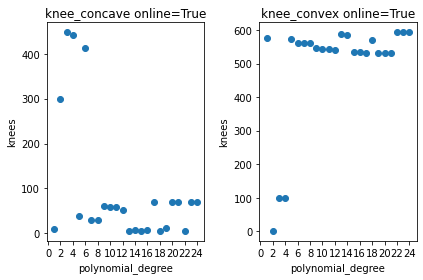

In [51]:
knee_range_concave = range(1, 25)
K_knee_concave = []

for k in knee_range_concave:
  kn4 = KneeLocator(k_range, cv_scores, curve='concave', direction='decreasing', 
                    online=True, interp_method= 'polynomial', polynomial_degree= k)
  K_knee_concave.append(kn4.knee)

knee_range_convex = range(1, 25)
K_knee_convex = []

for k in knee_range_convex:
  kn4 = KneeLocator(k_range, cv_scores, curve='convex', direction='decreasing', 
                    online=True, interp_method= 'polynomial', polynomial_degree= k)
  K_knee_convex.append(kn4.knee)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax0, ax1 = axes
ax0.scatter(knee_range_concave, K_knee_concave)
ax1.scatter(knee_range_convex, K_knee_convex)

ax0.set_title('knee_concave online=True')
ax1.set_title('knee_convex online=True')

ax0.set_ylabel('knees')
ax0.set_xlabel('polynomial_degree')
ax1.set_ylabel('knees')
ax1.set_xlabel('polynomial_degree')

ax0.set_xticks(np.arange(0, 25, 2))
ax1.set_xticks(np.arange(0, 25, 2))

fig.tight_layout();

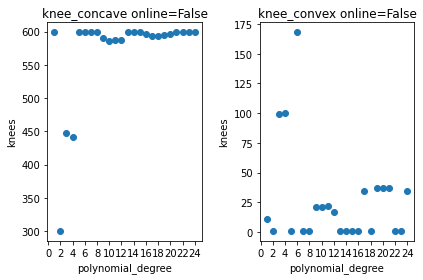

In [52]:
knee_range_concave = range(1, 25)
K_knee_concave = []

for k in knee_range_concave:
  kn4 = KneeLocator(k_range, cv_scores, curve='concave', direction='decreasing', online=False, interp_method= 'polynomial', polynomial_degree= k)
  K_knee_concave.append(kn4.knee)

knee_range_convex = range(1, 25)
K_knee_convex = []

for k in knee_range_convex:
  kn4 = KneeLocator(k_range, cv_scores, curve='convex', direction='decreasing', online=False, interp_method= 'polynomial', polynomial_degree= k)
  K_knee_convex.append(kn4.knee)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax0, ax1 = axes
ax0.scatter(knee_range_concave, K_knee_concave)
ax1.scatter(knee_range_convex, K_knee_convex)

ax0.set_title('knee_concave online=False')
ax1.set_title('knee_convex online=False')

ax0.set_ylabel('knees')
ax0.set_xlabel('polynomial_degree')
ax1.set_ylabel('knees')
ax1.set_xlabel('polynomial_degree')

ax0.set_xticks(np.arange(0, 25, 2))
ax1.set_xticks(np.arange(0, 25, 2))

fig.tight_layout();

14/12/2020: No se logro encontrar el Codo con la funcion kneelocator pero se logró limitar su localización; entre 98 y 140. Sin embargo, mediante observación se infiere un codo de 120 k

** 15/12/2020**: Se probó con 120 como codo pero no dio buenos resultados entonces se observo la gráfica de nuevo y se encontró un hombro en 45. usó y dio buenos resultados. 

**NUEVO 13/08/2021:** Con X normalizado vemos una cima en 9 k


Aquí miramos cual es la mejor proporción test-train segun accuarcy buscando ya sea un codo o un hombro (knee)

Looping over t:   0%|          | 0/50 [00:00<?, ?it/s]

knee - Codo de inflexión  Polinomial grado 2 concave online=True: 0.35 (k)
knee2 - Codo de inflexión  Polinomial grado 7 concave online=True: 0.98 (k)
knee3 - Codo de inflexión  Polinomial grado 1 concave online=True: 0.38 (k)
knee4 - Codo de inflexión  Polinomial grado 4 concave online=True: 0.35 (k)


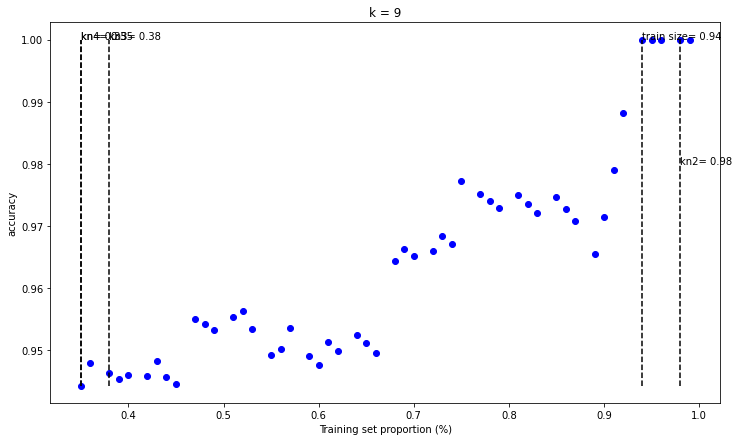

In [53]:
#from icecream import ic 
#ic.configureOutput(includeContext=True)

#t= np.linspace(0.5, 0.95, 40).tolist() #toca correr primero con 0.5 incial para depues correr con un valor menor como 0.2
#t= np.linspace(0.2, 0.99, 30).tolist()
t= np.linspace(0.35, 0.99, 50).tolist()
round_t = [round(num, 2) for num in t]
t= round_t
#########
veci = 9
#aquí va el numero de vecinos con el que se va a hacer la iteracion
knn = KNeighborsClassifier(n_neighbors = veci, n_jobs=-1,)#45)
#########


scores_mean= []
for s in tqdm(t, 
              total=50, 
              desc= "Looping over t"):

    #scores = []
    #for i in range(1,100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-s, 
                                                            random_state=0, stratify= y)
    knn.fit(X_train, y_train)
     #   scores.append(knn.score(X_test, y_test))
    #print(scores)
    scores_mean.append(knn.score(X_test, y_test))#np.mean(scores))    
#    plt.plot(s, np.mean(scores), 'bo')
plt.figure(figsize=(12,7))
plt.plot(t, scores_mean, 'bo')

#Descomentar sólo si se quiere hallar el knee de esta gráfica
min_score= pd.Series(scores_mean).min()
max_score= pd.Series(scores_mean).max()

from kneed import KneeLocator
knee_train = KneeLocator(t, scores_mean, curve='concave', direction='increasing', 
                         online=True, interp_method= 'polynomial', polynomial_degree= 2)
print(f'knee - Codo de inflexión  Polinomial grado 2 concave online=True: {knee_train.knee} (k)')
#knee_train.plot_knee() 
degree = 7
knee_train2 = KneeLocator(t, scores_mean, curve='concave', direction='increasing', 
                          online=True, interp_method= 'polynomial', polynomial_degree= degree)
print(f'knee2 - Codo de inflexión  Polinomial grado {degree} concave online=True: {knee_train2.knee} (k)')
#knee_train.plot_knee()
knee_train3 = KneeLocator(t, scores_mean, curve='concave', direction='increasing', 
                          online=False, interp_method= 'polynomial', polynomial_degree= 6)
print(f'knee3 - Codo de inflexión  Polinomial grado {1} concave online=True: {knee_train3.knee} (k)')

knee_train4 = KneeLocator(t, scores_mean, curve='concave', direction='increasing', 
                          online=True, interp_method= 'polynomial', polynomial_degree= 4)
print(f'knee4 - Codo de inflexión  Polinomial grado {4} concave online=True: {knee_train4.knee} (k)')


plt.xlabel('Training set proportion (%)')
plt.ylabel('accuracy')
plt.title(f'k = {veci}')

plt.plot([knee_train.knee,knee_train.knee],[min_score,max_score],
         color = 'black',linestyle='dashed')
plt.text(knee_train.knee, max_score, f'kn= {knee_train.knee}');

plt.plot([knee_train2.knee,knee_train2.knee],[min_score,max_score],
         color = 'black',linestyle='dashed')
plt.text(knee_train2.knee, max_score-0.02, f'kn2= {knee_train2.knee}');

plt.plot([knee_train3.knee,knee_train3.knee],[min_score,max_score],
         color = 'black',linestyle='dashed')
plt.text(knee_train3.knee, max_score, f'kn3= {knee_train3.knee}');

plt.plot([knee_train4.knee,knee_train4.knee],[min_score,max_score],
         color = 'black',linestyle='dashed')
plt.text(knee_train4.knee, max_score, f'kn4= {knee_train4.knee}');

t_max_score = t[scores_mean.index(np.max(scores_mean))]
plt.plot([t_max_score, t_max_score],[min_score,max_score],
         color = 'black',linestyle='dashed')
plt.text(t_max_score, max_score, f'train size= {t_max_score}');

#Este algoritmo siempre que se ejecute dara resultados diferentes
#dado que: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1-s)
          #knn.fit(X_train, y_train)
#separa el conjunto de datos en un set de entrenamineto y otro de prueba 
#tomando siempre valores aleatorios diferentes para cada set


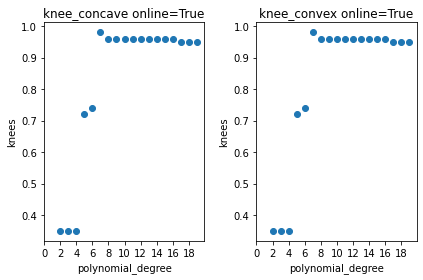

In [54]:
knee_range_set_concv = range(1,20)
K_knee_set_concv = []

for k in knee_range_set_concv:
  knee_train = KneeLocator(t, scores_mean, curve='concave', direction='increasing', 
                           online=True, interp_method= 'polynomial', polynomial_degree= k)
  K_knee_set_concv.append(knee_train.knee)

knee_range_set_convx = range(1,20)
K_knee_set_convx = []

for k in knee_range_set_convx:
  knee_train = KneeLocator(t, scores_mean, curve='concave', direction='increasing', 
                           online=True, interp_method= 'polynomial', polynomial_degree= k)
  K_knee_set_convx.append(knee_train.knee)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax0, ax1 = axes
ax0.scatter(knee_range_set_concv, K_knee_set_concv)
ax1.scatter(knee_range_set_convx, K_knee_set_convx)

ax0.set_title('knee_concave online=True')
ax1.set_title('knee_convex online=True')

ax0.set_ylabel('knees')
ax0.set_xlabel('polynomial_degree')
ax1.set_ylabel('knees')
ax1.set_xlabel('polynomial_degree')

ax0.set_xticks(np.arange(0, 20, 2))
ax1.set_xticks(np.arange(0, 20, 2))

fig.tight_layout();

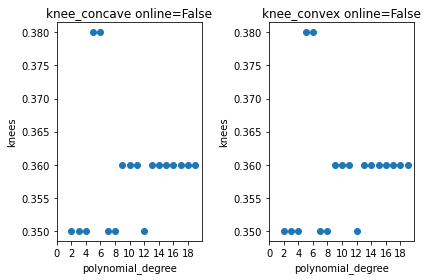

In [55]:
knee_range_set_concv = range(1,20)
K_knee_set_concv = []

for k in knee_range_set_concv:
  knee_train = KneeLocator(t, scores_mean, curve='concave', direction='increasing', 
                           online=False, interp_method= 'polynomial', polynomial_degree= k)
  K_knee_set_concv.append(knee_train.knee)

knee_range_set_convx = range(1,20)
K_knee_set_convx = []

for k in knee_range_set_convx:
  knee_train = KneeLocator(t, scores_mean, curve='concave', direction='increasing', 
                           online=False, interp_method= 'polynomial', polynomial_degree= k)
  K_knee_set_convx.append(knee_train.knee)

fig, axes = plt.subplots(nrows=1, ncols=2)
ax0, ax1 = axes
ax0.scatter(knee_range_set_concv, K_knee_set_concv)
ax1.scatter(knee_range_set_convx, K_knee_set_convx)

ax0.set_title('knee_concave online=False')
ax1.set_title('knee_convex online=False')

ax0.set_ylabel('knees')
ax0.set_xlabel('polynomial_degree')
ax1.set_ylabel('knees')
ax1.set_xlabel('polynomial_degree')

ax0.set_xticks(np.arange(0, 20, 2))
ax1.set_xticks(np.arange(0, 20, 2))

fig.tight_layout();

**Conclusión**: El set de entrenamiento no pueod ser hallado mediante la función kneelocator pero se puedo hallar una cima en 0.73

**13/08/2021**: Cambiando los parametros del train test split; como definiendo una semilla aleatoria encontramos una nueva cima 0.9 con 45 k

# Modelo (neighbors: 9, test size: 0.6%)
---
Para un modelo donde sólo conocieramos las coordenadas y no más


In [56]:
###################
TEST_SIZE = 1-t_max_score
###################
print(f'test size: {TEST_SIZE:.2f}')

# default is 75% / 25% train-test split, pero aquí se utilizo segun el codigo anterior 74/26
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= TEST_SIZE,
                                                    random_state=0, stratify= y)

test size: 0.06


### Creamos KNeighborsClassifier (Clasificador)


In [57]:
#################
n_neighbors = 9
#################
knn = KNeighborsClassifier(n_neighbors = n_neighbors, n_jobs=-1)

Entrenamos el clasificador

In [58]:
x_train_sliced = X_train[:,0:2]
x_test_sliced = X_test[:,0:2]

In [59]:
knn.fit(x_train_sliced, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                     weights='uniform')

Calculamos la exactitud del clasificador

In [60]:
score = knn.score(x_test_sliced, y_test) 
score

0.8095238095238095

Convertimos la variable categorica ordinal 'Etapa_termica' en una variable numérica de 1 a 10 llamada 'No_etapa'

In [61]:
df_Flujo_calor['No_class']= list(map(lambda x: 1 if x == 'Frío' else 2 if x == 'Neutro' else 0 if x == 'Caliente' else False, 
                                     df_Flujo_calor['Clasificador']))

df_Flujo_calor.head()

,Codigo,lon,lat,Profundidad,Flujo_calor,HFU,Pesos,Flux_x_wts,geometry,Sed_thickness (m),Age (Ma),Etapa_termica,No_etapa,Lister HFU,obs-teo HFU,Clasificador,Clasif_encode,No_class
0,27HF23,-86.86670,3.537222,-2136.0,65.85,1.572725,0.942231,62.045937,POINT (-86.86669999999998 3.537222222),279.0,10.1,Oligocene,4,3.775901,-2.203176,Neutro,2,2
1,28HF24,-86.99115,2.950989,-2870.0,267.00,6.376881,0.792270,211.536033,POINT (-86.99115 2.950988889),211.0,7.6,Quaternary,1,4.352858,2.024023,Neutro,2,2
2,29HF25,-86.90680,2.720539,-2690.0,211.00,5.039408,0.792270,167.168925,POINT (-86.90679999999998 2.720538889),203.0,5.9,Quaternary,1,4.940322,0.099086,Neutro,2,2
3,31HF27,-87.01960,2.150989,-2824.0,187.00,4.466205,0.660685,123.548114,POINT (-87.0196 2.150988889),159.0,3.6,Pliocene,2,6.324555,-1.858350,Neutro,2,2
4,32HF28,-87.05290,2.034306,-2503.0,234.00,5.588727,0.660685,154.600314,POINT (-87.05289999999999 2.0343055555),145.0,3.1,Quaternary,1,6.815542,-1.226815,Neutro,2,2


Probamos el clasificador con una muestra que no este en el Dataset

In [62]:
# relacionamos la etapa termica con un numero
nombre_etapa_termica = dict(zip(df_Flujo_calor.Clasif_encode.unique(), 
                                df_Flujo_calor.Clasificador.unique()))   
nombre_etapa_termica

{0: 'Caliente', 1: 'Frío', 2: 'Neutro'}

In [63]:
# Ejemplo sea una muestra con lon= promedio, lat= prmedio, Profundidad= promedio, Flujo_calor= promerio
y_pred = knn.predict(x_test_sliced)
y_pred

array([2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2,
       1, 2, 2, 1, 1, 2, 0, 1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 0, 1, 1, 2, 2, 1])

aquí nos damos cuenta que un dato promedio del data frame tendra una etapa térmica neutra

In [64]:
y_test.unique()

array([2, 1, 0])

In [65]:
def list_confusion_matrix(cm,classes):
  df = pd.DataFrame(data = cm,
                    index = pd.MultiIndex.from_product([['Valor real'], classes]),
                    columns = pd.MultiIndex.from_product([['Valor predicho'], classes]))
  
  return df

In [66]:
# Generamos y mostramos la matriz de confusión.
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, y_pred)  
list_confusion_matrix(mat, [str(clust) for clust in np.unique(y)]) 

Valor predicho        
                          0   1   2
Valor real 0              4   0   1
           1              0  17   5
           2              2   4  30

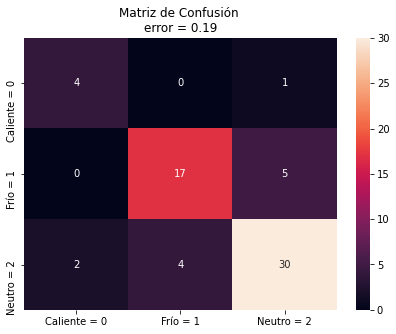

In [67]:
etiquetas = ['Caliente = 0', 'Frío = 1', 'Neutro = 2']
fig, ax = plt.subplots(1,1, figsize=(7, 5))
ax = sns.heatmap(mat, annot=True, 
            xticklabels=etiquetas, 
            yticklabels=etiquetas).set_title(f'Matriz de Confusión \nerror = {1-score:.2f}')



In [68]:
from sklearn.metrics import classification_report
target_names = ['Caliente = 0', 'Frío = 1', 'Neutro = 2']
print(classification_report(y_test, y_pred,target_names=target_names))

              precision    recall  f1-score   support

Caliente = 0       0.67      0.80      0.73         5
    Frío = 1       0.81      0.77      0.79        22
  Neutro = 2       0.83      0.83      0.83        36

    accuracy                           0.81        63
   macro avg       0.77      0.80      0.78        63
weighted avg       0.81      0.81      0.81        63



### Graficamos los limites de desicion de los k-NN classifier

In [69]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import matplotlib.patches as mpatches
from sklearn.neighbors import KNeighborsClassifier
##debugging
from icecream import ic 
ic.configureOutput(includeContext=True)

def plot_EtapasCalor_knn(X_train, y_train, n_neighbors, weights, X_test, y_test):

  #X_mat y y_mat son para crear la grilla
  X_mat = X[:,0:2]
  y_mat = y.values
  clf = KNeighborsClassifier(n_neighbors, weights=weights, )
  #clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
  clf.fit(X_train[:,0:2], y_train)
  # Plot the decision boundary by assigning a color in the color map
  # to each mesh point
  mesh_step_size = .01  # step size in the mesh, para mayor resolución usa .01
  
  x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
  y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1

  xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size),
                       np.arange(y_min, y_max, mesh_step_size))
  
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])#, ss.ravel(), ee.ravel()])
  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  # Create color maps
  cmap_light = ListedColormap([ '#FA9856', '#78B0D2', '#FAFDC6',])
  cmap_bold  = ListedColormap([ '#A80326', '#343F99', '#D2D4A6',])
  plt.figure(figsize=(17,8))
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
  # Plot training points
  plot_symbol_size = 40
  plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, 
              c=y, cmap=cmap_bold, edgecolor = 'black')
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  patch0 = mpatches.Patch(color='#343F99', label='Bajo')
  patch1 = mpatches.Patch(color='#D2D4A6', label='Normal')
  patch2 = mpatches.Patch(color='#A80326', label='Alto')

  plt.title(f"k = {n_neighbors} error: {1-clf.score(X_test[:,0:2], y_test):.2f}")
  plt.legend(handles=[patch0, patch1, patch2], bbox_to_anchor=(0.99, 1))
  plt.xlabel('Longitud')
  plt.ylabel('Latitud')


In [70]:
from google.colab import files

df_Flujo_calor.to_csv('df_Flujo_calor3.csv')
files.download('df_Flujo_calor3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Cramos un arreglo de pesos hallados con declustering para cada dato con lo que se

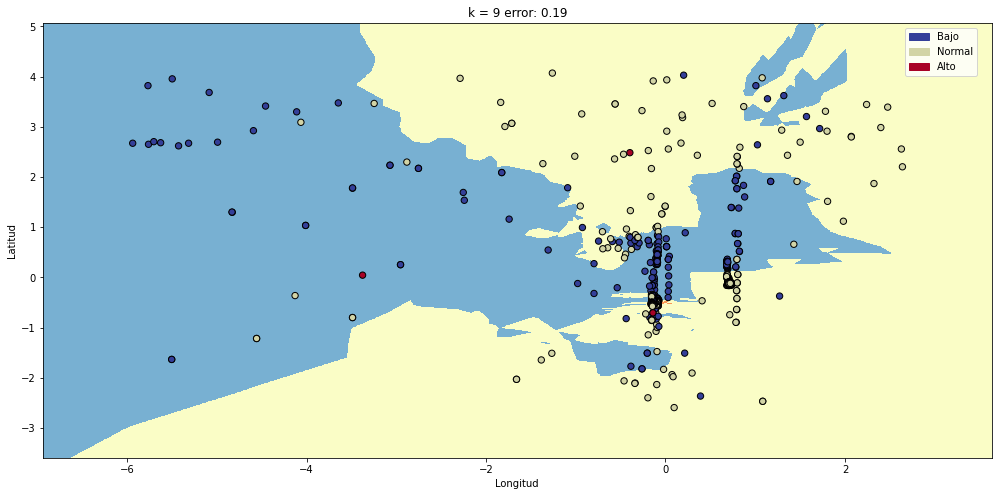

In [73]:
#por requerir gran cantodad de memoria se deja comentado
#tiempo de ejecución 2:03 min
plot_EtapasCalor_knn(X_train, y_train, n_neighbors, 'uniform', X_test, y_test)
plt.savefig("Modelo.jpg", bbox_inches='tight')

### Conclusiones 
---
1. A pesar de que se observó una correlación positiva significativa entre las variables flujo de calor y profundidad según el test de Spearman, al realizar el diagrama de dispersión entre estas variables no se observa una correlación clara y por otro lado parece estar sesgada por ciertas zonas profundas con mayor densidad de muestreo.

2. Se necesita un muestreo con una distribución más uniforme, para tener un conocimiento más detallado del flujo de calor en la Cuenca Panamá, puesto que los análisis estadísticos realizados parecen presentar cierto sesgo asociado a la densidad y distribución de muestreo.

3. Basado en los datos de flujo de calor clasificados por etapas térmicas, se puede concluir que la Cuenca Panamá presenta un comportamiento térmico correspondiente a una placa joven del Cenozoico Tardío, sin embargo, no se descarta el sesgo asociado a la distribución geográfica de los datos, los cuales se concentran en zonas cercanas a centros de expansión oceánicos donde hay una gran actividad volcánica.

4. La correlación negativa entre el flujo de calor y las coordenadas latitud y longitud puede estar asociada a la orientación de las principales características geomorfológicas del fondo oceánico; dado que los sistemas de dorsales meso-oceánicas ubicadas en la Cuenca Panamá, se encuentran localizadas cerca al ecuador geográfico con una orientación oeste-este, junto con el punto caliente de Galápagos que se encuentra a longitudes bajas y que la trinchera asociada a la zona de subducción de la placa Nazca bajo Suramérica, presenta una orientación norte-sur, es posible inferir que las muestras del flujo de calor tomadas en las cercanías de las dorsales y las islas Galápagos (latitudes y longitudes bajas), presentarán flujos de calor altos, mientras que las muestras de calor tomadas lejos de los centros de expansión y en cercanías de la zona de subducción (latitudes y longitudes altas), presentarán flujos de calor menores.

#### Referencias



Pollack, H. N., Hurter, S. J., & Johnson, J. R. (1993). Heat flow from the Earth’s interior: Analysis of the global data set. Reviews of Geophysics, 31(3), 267–280. https://doi.org/10.1029/93RG01249